# ClimateNet AR Analysis: MERRA data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
import datetime
import pandas as pd

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '5GiB' # PBSCluster specification
nmem2 = '5GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(25)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42883 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/42883/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/42883/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:38203,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/42883/status,Total threads: 0
Started: Just now,Total memory: 0 B


## MERRA ARs

In [4]:
merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier1/ClimateNet_DL/' # tier1, 3hrly
#merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

In [5]:
file_years = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)
#file_years = '*.nc4' # for all years; 1980 - June 2017

### Preprocessing function to (optionally) subset regionally

In [6]:
# MERRA2 lons are -180 / +180
lat_bounds_merra = slice(32,55)
lon_bounds_merra = slice(-130,-105)

In [7]:
def preprocess_region_merra(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_merra,lon=lon_bounds_merra)

### Read in data

In [8]:
#merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region_merra)
merra_cnet

<xarray.DataArray 'ar_binary_tag' (time: 51128, lat: 47, lon: 41)>
dask.array<concatenate, shape=(51128, 47, 41), dtype=int8, chunksize=(500, 47, 41), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 53.0 53.5 54.0 54.5 55.0
  * lon      (lon) float32 -130.0 -129.4 -128.8 -128.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2017-06-30T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [9]:
# if not using preprocess
#merra_ar_full = merra_cnet.ar_binary_tag
merra_ar_full = merra_cnet
#merra_ar_full

In [10]:
# subset 2000-2015 to match CESM years (number of time indices will not match due to CESM shifted start and MERRA leap years)
merra_ar = merra_ar_full.sel(time=slice("2000","2015"))

# or look at all years
#merra_ar = merra_ar_full

merra_ar

<xarray.DataArray 'ar_binary_tag' (time: 46752, lat: 47, lon: 41)>
dask.array<getitem, shape=(46752, 47, 41), dtype=int8, chunksize=(500, 47, 41), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 53.0 53.5 54.0 54.5 55.0
  * lon      (lon) float32 -130.0 -129.4 -128.8 -128.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

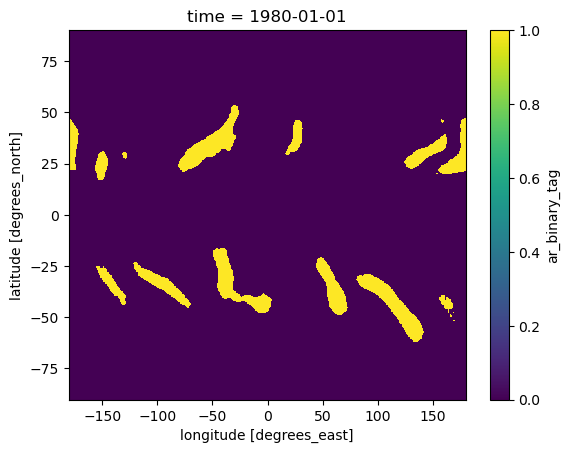

In [69]:
merra_ar.isel(time=0).plot();

### Read in MERRA2 landfrac
Actually stored as 'ocnfrac'\
CGD machines: /project/ccr/shields/merra2/merra2_ocn_land_fraction.nc\
CISL machines: /glade/derecho/scratch/shields/ARTMIP/grids/merra2_ocn_land_fraction.nc 

In [14]:
merra_landfrac_file = "/glade/derecho/scratch/shields/ARTMIP/grids/merra2_ocn_land_fraction.nc"
merra_landfrac_ds = xr.open_dataset(merra_landfrac_file)
#merra_landfrac_ds

In [15]:
merra_landfrac = 1-(merra_landfrac_ds.ocnfrac.sel(lat=lat_bounds_merra,lon=lon_bounds_merra))
#merra_landfrac

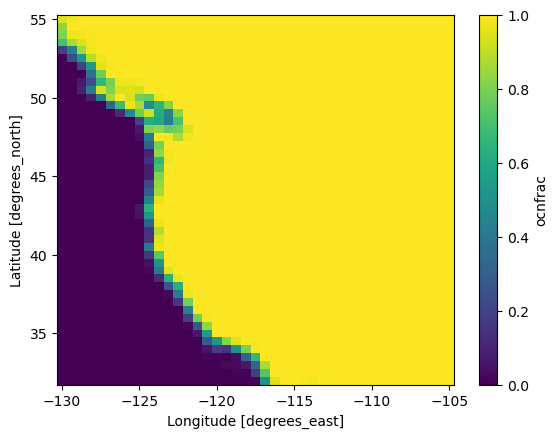

In [16]:
merra_landfrac.plot();

### Global AR frequency maps

In [70]:
npercentARs = 100*(merra_ar.sum(dim='time'))/len(merra_ar.time)

In [58]:
npercentARs.max().values

array(49.63923112)

/glade/derecho/scratch/kdagon/tmp/ipykernel_18709/2769021420.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12)


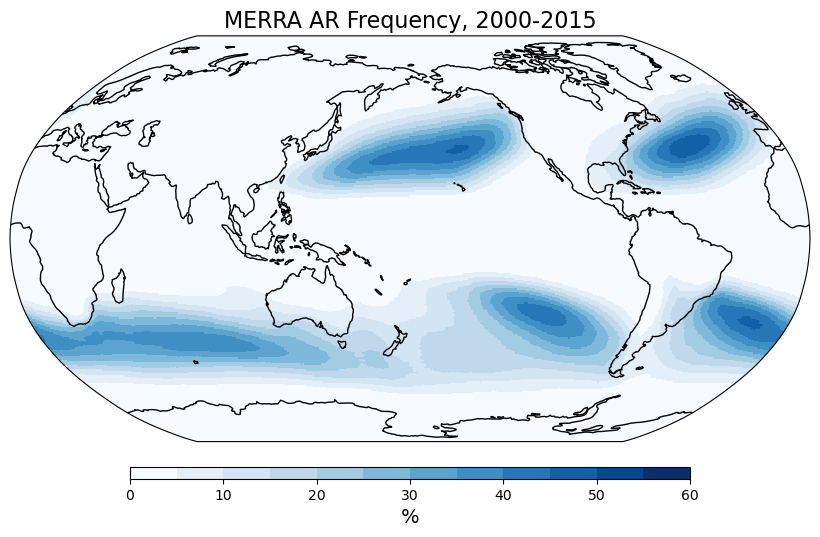

In [59]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)
vmax=60

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_MERRA2_tier1_2000-2015.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_MERRA2_tier2_2000-2015.png', bbox_inches='tight')

### Regional heatmap

In [35]:
npercentARs.lon

<xarray.DataArray 'lon' (lon: 576)>
array([-180.   , -179.375, -178.75 , ...,  178.125,  178.75 ,  179.375],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [36]:
lat_bounds = slice(25,65)
lon_bounds = slice(-180,-110) # MERRA convention

In [37]:
npercentARs_WUS = npercentARs.sel(lat=lat_bounds, lon=lon_bounds)
npercentARs_WUS

<xarray.DataArray 'ar_binary_tag' (lat: 81, lon: 113)>
dask.array<getitem, shape=(81, 113), dtype=float64, chunksize=(81, 113), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -111.2 -110.6 -110.0

/glade/derecho/scratch/kdagon/tmp/ipykernel_18709/2054930753.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 8)


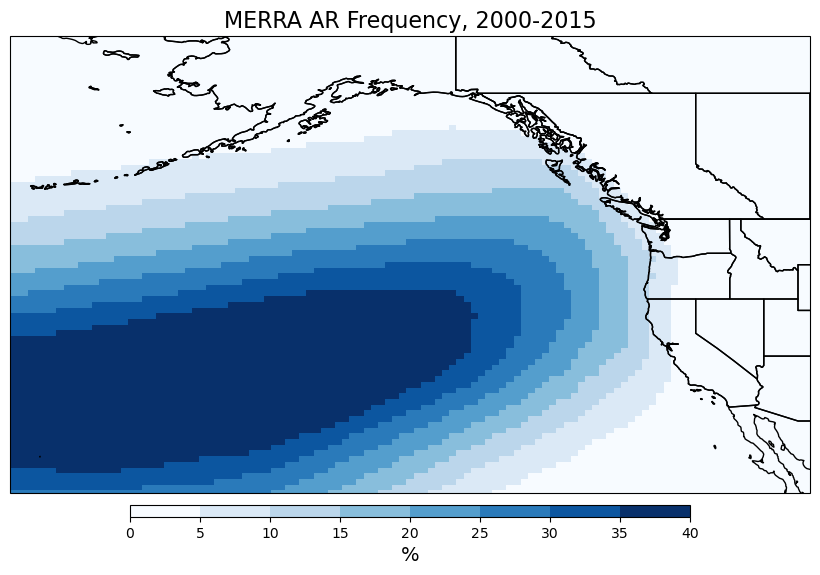

In [43]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 8)

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

lat = npercentARs_WUS.lat
lon = npercentARs_WUS.lon
pc = ax.pcolormesh(lon, lat, npercentARs_WUS, cmap=cmap, vmin=0, vmax=40, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

ax.coastlines(zorder=1)
ax.add_feature(cfeature.BORDERS, zorder=2) # duplicative?
ax.add_feature(cfeature.STATES, zorder=3)

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_tier1_2000-2015.png', bbox_inches='tight')

### Seasonal heatmap

In [71]:
season_lengths = merra_ar.time.groupby('time.season').count()
season_lengths

<xarray.DataArray 'time' (season: 4)>
array([27192, 27472, 27968, 26936])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    standard_name:  time
    axis:           T
    long_name:      time

In [72]:
npercentARs_byseason = 100*(merra_ar.groupby('time.season').sum(dim='time'))/season_lengths
npercentARs_byseason

<xarray.DataArray (season: 4, lat: 361, lon: 576)>
dask.array<truediv, shape=(4, 361, 576), dtype=float64, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [73]:
npercentARs_byseason_WUS = npercentARs_byseason.sel(lat=lat_bounds, lon=lon_bounds)

/glade/derecho/scratch/kdagon/tmp/ipykernel_18709/1815655.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12) # ARTMIP region


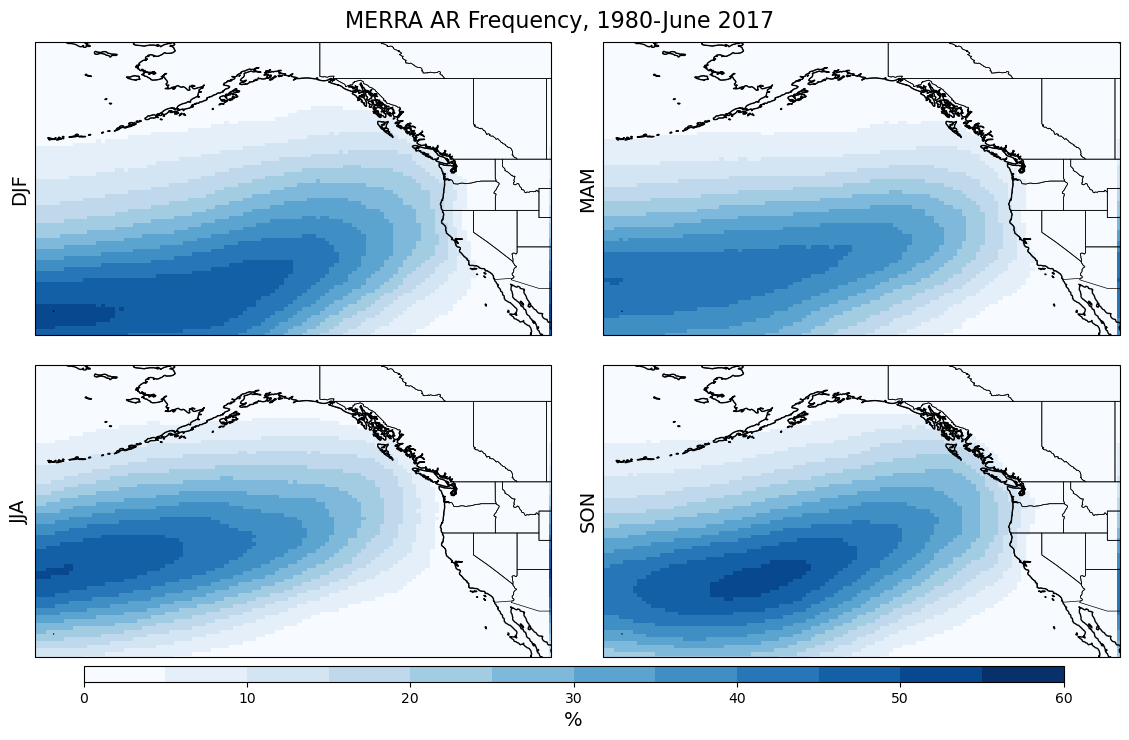

In [74]:
# a nicer plot
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 12) # ARTMIP region

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason_WUS.sel(season=season), coord=npercentARs_byseason_WUS.lon)
    lat = npercentARs_byseason_WUS.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=60, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#fig.suptitle('MERRA AR Frequency, 2000-2015', fontsize=16, y=0.92)
fig.suptitle('MERRA AR Frequency, 1980-June 2017', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_tier1_2000-2015_byseason.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_tier1_1980-2017_byseason.png', bbox_inches='tight')

### Monthly heatmaps/hovmollers

In [11]:
# getting the number of time points in each month
month_lengths = merra_ar.time.groupby('time.month').count()
month_lengths

<xarray.DataArray 'time' (month: 12)>
array([3968, 3616, 3968, 3840, 3968, 3840, 3968, 3968, 3840, 3968, 3840,
       3968])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  time
    axis:           T
    long_name:      time

In [12]:
npercentARs_bymonth = 100*(merra_ar.groupby('time.month').sum(dim='time'))/month_lengths

In [13]:
npercentARs_bymonth = npercentARs_bymonth.persist()

### Zonal means by month for Hovmollers

In [22]:
npercentARs_bymonth_zmean = npercentARs_bymonth.sel(lon=slice(-130,-105)).mean(dim='lon') # same lons as counts at coastlines ARTMIP comparison
npercentARs_bymonth_zmean

<xarray.DataArray (month: 12, lat: 47)>
dask.array<mean_agg-aggregate, shape=(12, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 53.0 53.5 54.0 54.5 55.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [23]:
npercentARs_bymonth_zmean.max().values

array(9.50039339)

/glade/derecho/scratch/kdagon/tmp/ipykernel_50755/386221001.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12)


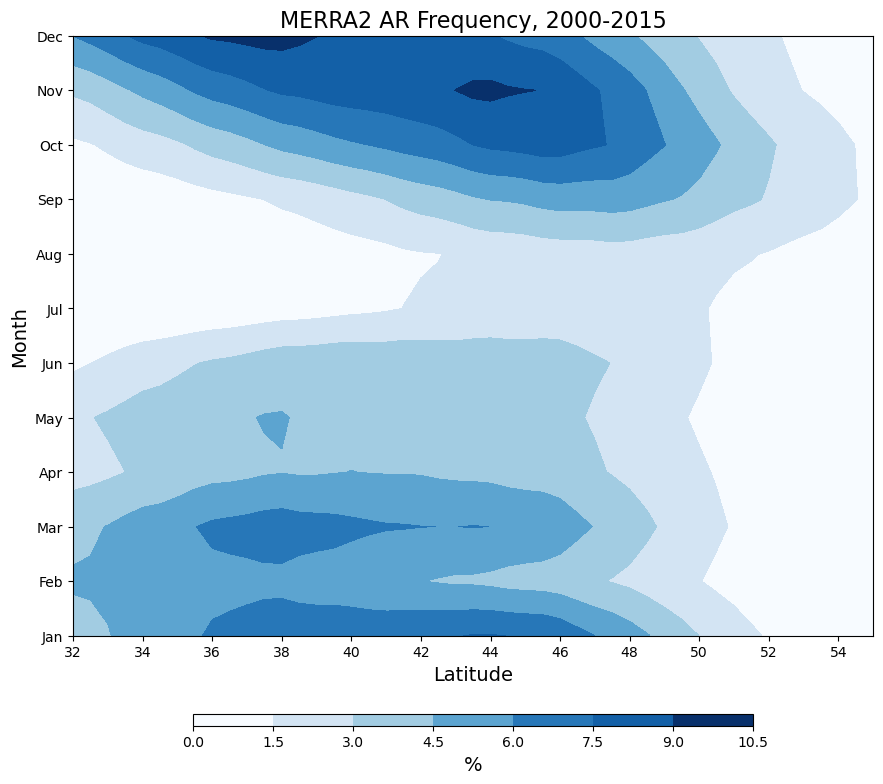

In [25]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)

ax = fig.add_axes([0.,0.,1.,1.])

#lat = npercentARs_bymonth_zmean.lat
lat = npercentARs_bymonth_zmean.lat.sel(lat=slice(32,55)) #artmip lats

mon = npercentARs_bymonth_zmean.month
# full WUS longitudes
#pc = ax.pcolormesh(mon, lat, npercentARs_bymonth_zmean.transpose(), cmap=cmap, vmin=0, vmax=30)
#pc = ax.contourf(mon, lat, npercentARs_bymonth_zmean.transpose(), cmap=cmap, vmin=0, vmax=30)
# restricted longitudes
#pc = ax.contourf(mon, lat, npercentARs_bymonth_zmean.transpose(), cmap=cmap, vmin=0, vmax=10)
# month x lat
pc = ax.contourf(lat, mon, npercentARs_bymonth_zmean.sel(lat=slice(32,55)), cmap=cmap, vmin=0, vmax=10)

# default is to order Jan-Dec from bottom to top
#ax.set_xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_yticks(np.arange(12)+1, months)

# July-June month ordering, y axis goes down in time -- still in progress to get this to work
# currently doesn't interpolate btw Dec-Jan and the data is flipped across the discontinuity
#mon_alt = xr.concat([npercentARs_bymonth_zmean.month.sel(month=slice(7,12)), npercentARs_bymonth_zmean.month.sel(month=slice(1,6))], dim='month')
#pc = ax.contourf(lat, mon_alt.isel(month=slice(None, None, -1)), npercentARs_bymonth_zmean.isel(month=slice(None, None, -1)).sel(lat=slice(32,55)), cmap=cmap, vmin=0, vmax=10) #month x lat
#months_alt = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
#ax.set_yticks(np.arange(12)+1, months_alt[::-1])

ax.set_ylabel('Month', fontsize=14)

ax.set_xlabel('Latitude', fontsize=14)

# add more latitude labels
lat_labels = np.arange(32, 55, 2)
ax.set_xticks(lat_labels)

# add colorbar
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA2 AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_bymonth_zmean.png', bbox_inches='tight')

### Use landfrac to define coastal ARs
Are these longitude bounds too narrow? How to define "landfalling ARs"

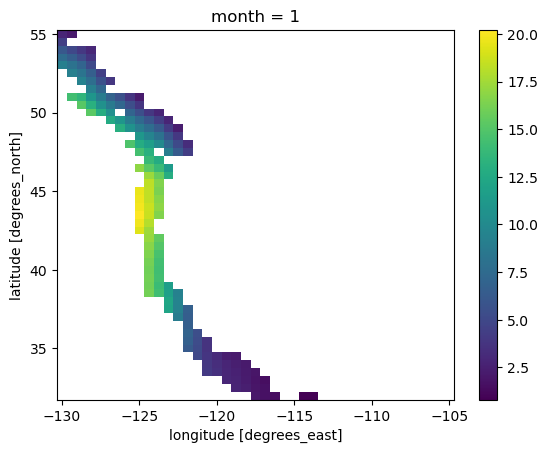

In [17]:
npercentARs_bymonth.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).sel(month=1).plot();

In [19]:
npercentARs_bymonth_coastal_zmean = npercentARs_bymonth.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).sel(lon=slice(-130,-105)).mean(dim='lon') # same lons as counts at coastlines ARTMIP comparison
npercentARs_bymonth_coastal_zmean

<xarray.DataArray (month: 12, lat: 47)>
dask.array<mean_agg-aggregate, shape=(12, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 53.0 53.5 54.0 54.5 55.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [33]:
npercentARs_bymonth_coastal_zmean.max().values

array(23.63071237)

/glade/derecho/scratch/kdagon/tmp/ipykernel_12922/2090305579.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12)


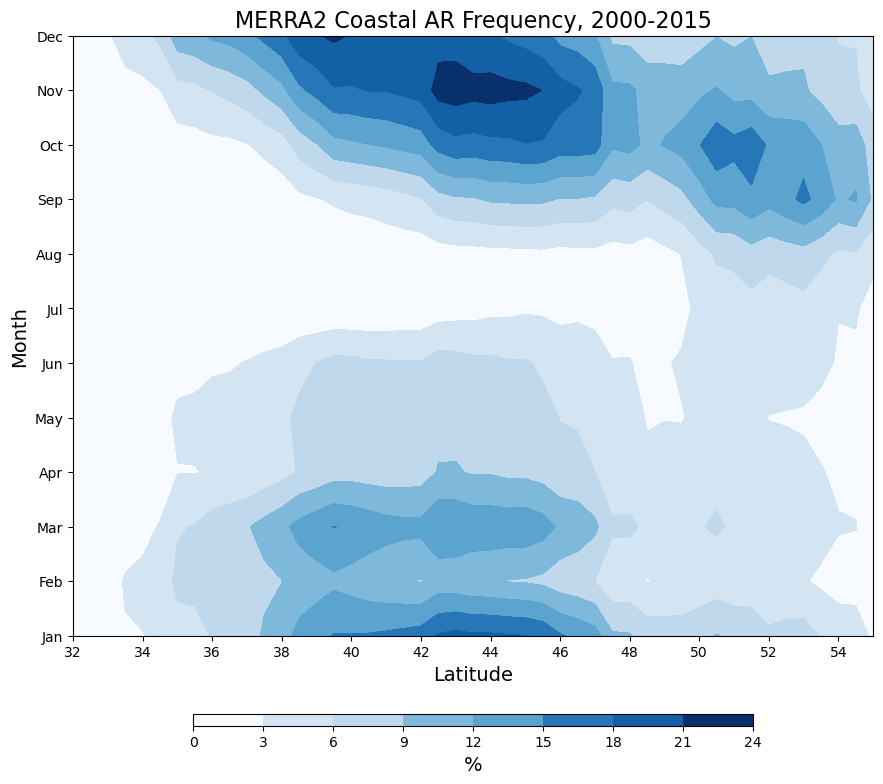

In [21]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)

ax = fig.add_axes([0.,0.,1.,1.])

lat = npercentARs_bymonth_coastal_zmean.lat.sel(lat=slice(32,55)) #artmip lats

mon = npercentARs_bymonth_coastal_zmean.month
# month x lat
pc = ax.contourf(lat, mon, npercentARs_bymonth_coastal_zmean.sel(lat=slice(32,55)), cmap=cmap, vmin=0, vmax=24)

# default is to order Jan-Dec from bottom to top
#ax.set_xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_yticks(np.arange(12)+1, months)

ax.set_ylabel('Month', fontsize=14)

ax.set_xlabel('Latitude', fontsize=14)

# add more latitude labels
lat_labels = np.arange(32, 55, 2)
ax.set_xticks(lat_labels)

# add colorbar
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA2 Coastal AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_bymonth_coastal_zmean.png', bbox_inches='tight')

## MERRA 3hrly data

In [4]:
merra_data_path = "/glade/campaign/collections/cdg/data/ARTMIP/merra2_2000-2017/" # no time coordinate information in these files, goes through June 30, 2017
#merra_data_path = "/glade/campaign/collections/cdg/data/ARTMIP/FULL_2D_MERRA2/" # yearly folders; time as "record" dimension

In [5]:
merra_data_files = "*.nc" # ideally subset for 2000-2015...but can't figure out how to do that with a single wildcard so split into two
#merra_data_files = "*200001*.nc" # start by testing with year 2000 / month Jan files only
#merra_data_files = "*2000*.nc" # year 2000 files only

#merra_data_files_1 = "*200[0-9]*" # 2000-2009
#merra_data_files_2 = "*_201[0-5]*" # 2010-2015

# for yearly folders, starting with 2000
#merra_data_files = "2000/*.nc"

### Preprocessing function to subset variables

In [6]:
def preprocess_IWV(ds):
    ds = ds.expand_dims(time = [datetime.datetime.now()]) # add an arbitrary date (today) as placeholder
    #ds = ds.chunk({'time':500}) # rechunk in time - doesn't work here, have to rechunk after reading in
    return ds['IWV']

### Read in data
5/1/24: 20 workers with 5GB each takes 5-6min but running out of Hub memory\
Another option is time averaging with NCO before reading in 3hrly data - but may not work without time coordinate\
What time frequency do I need to compare MERRA/CESM output? Monthly means?\
5/2/24: Monthly mean data generated below; can skip these steps

In [7]:
%%time
merra_dataset = xr.open_mfdataset(merra_data_path+merra_data_files, concat_dim='time', combine='nested', parallel=True, preprocess=preprocess_IWV)
#merra_dataset = xr.open_mfdataset(merra_data_path+merra_data_files, concat_dim='record', combine='nested', chunks={'record':500}, parallel=True, preprocess=preprocess_IWV)
merra_dataset

# two dataset approach
#merra_dataset_1 = xr.open_mfdataset(merra_data_path+merra_data_files_1, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_IWV)
#merra_dataset_1

#merra_dataset_2 = xr.open_mfdataset(merra_data_path+merra_data_files_2, concat_dim='time', combine='nested', parallel=True, preprocess=preprocess_IWV)
#merra_dataset_2

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 23.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 3min 25s, sys: 10.7 s, total: 3min 36s
Wall time: 5min 3s


<xarray.DataArray 'IWV' (time: 51128, lat: 361, lon: 576)>
dask.array<concatenate, shape=(51128, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2024-05-02T11:43:22.151723 ... 2024-05-02T...
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

### Rechunk in time

In [8]:
merra_dataset = merra_dataset.chunk({'time':500})
merra_dataset

<xarray.DataArray 'IWV' (time: 51128, lat: 361, lon: 576)>
dask.array<rechunk-merge, shape=(51128, 361, 576), dtype=float32, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2024-05-02T11:43:22.151723 ... 2024-05-02T...
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

### Fix datetime

In [9]:
# create datetimes for merra data
#merra_dt = np.arange(np.datetime64('2000-01-01T00:00:00.000000000'), np.datetime64('2000-02-01T00:00:00.000000000'), np.timedelta64(3, "h")) # following MERRA datetime format from CGNet MERRA files
#merra_dt = np.arange(np.datetime64('2000-01-01T00:00:00.000000000'), np.datetime64('2001-01-01T00:00:00.000000000'), np.timedelta64(3, "h"))
merra_dt = np.arange(np.datetime64('2000-01-01T00:00:00.000000000'), np.datetime64('2017-07-01T00:00:00.000000000'), np.timedelta64(3, "h"))
#merra_dt

# assign to merra data
merra_dataset['time'] = merra_dt
merra_dataset

<xarray.DataArray 'IWV' (time: 51128, lat: 361, lon: 576)>
dask.array<rechunk-merge, shape=(51128, 361, 576), dtype=float32, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2000-01-01 ... 2017-06-30T21:00:00
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

### Subset for CESM years

In [10]:
merra_IWV = merra_dataset.sel(time=slice('2000-01-01', '2015-12-31'))
merra_IWV

<xarray.DataArray 'IWV' (time: 46752, lat: 361, lon: 576)>
dask.array<getitem, shape=(46752, 361, 576), dtype=float32, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 61.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


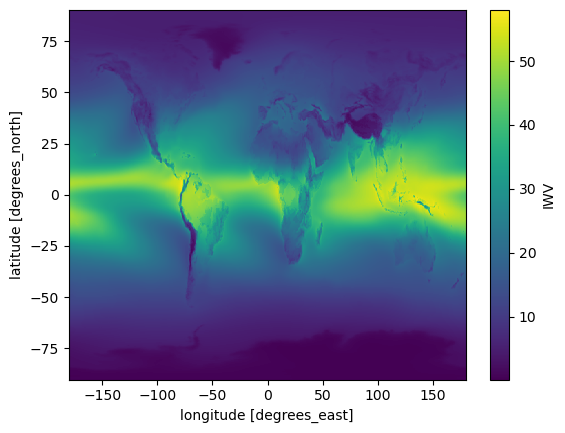

In [11]:
merra_IWV.mean(dim='time').plot();

### Create monthly means for easier processing

In [12]:
merra_IWV_month = merra_IWV.resample(time="M").mean()
merra_IWV_month

<xarray.DataArray 'IWV' (time: 192, lat: 361, lon: 576)>
dask.array<stack, shape=(192, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2015-12-31
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

### Reset the time values to month starts

In [25]:
#offset = pd.tseries.frequencies.to_offset("M") # this shifts to month end
#offset
#merra_IWV_month["time"] = merra_IWV_month.get_index("time") + offset
#merra_IWV_month

In [23]:
merra_month_dt = np.arange(np.datetime64('2000-01'), np.datetime64('2016-01'), np.timedelta64(1, "M"))
#merra_month_dt
#len(merra_month_dt)

# assign to merra data
merra_IWV_month['time'] = merra_month_dt
merra_IWV_month

/glade/derecho/scratch/kdagon/tmp/ipykernel_67844/3088991827.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  merra_IWV_month['time'] = merra_month_dt


<xarray.DataArray 'IWV' (time: 192, lat: 361, lon: 576)>
dask.array<stack, shape=(192, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2015-12-01
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

In [27]:
# testing groupby operations
merra_IWV_month.groupby('time.month').mean()

<xarray.DataArray 'IWV' (month: 12, lat: 361, lon: 576)>
dask.array<stack, shape=(12, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

In [28]:
merra_IWV_month.groupby('time.season').mean()

<xarray.DataArray 'IWV' (season: 4, lat: 361, lon: 576)>
dask.array<stack, shape=(4, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

### Save out monthly data

In [29]:
merra_IWV_month.to_netcdf("/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/MERRA2_IWV_monthly_2000-2015.nc")

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 63.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### Clear memory

In [ ]:
# optional, if monthly data is already generated can skip
del merra_dataset
del merra_IWV
del merra_IWV_month

In [36]:
# checking memory usage by variable
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('Client', 1688),
 ('PBSCluster', 1688),
 ('merra_month_dt', 1648),
 ('add_cyclic_point', 152),
 ('open', 152),
 ('preprocess_IWV', 152),
 ('merra_data_path', 110),
 ('ccrs', 72),
 ('cfeature', 72),
 ('mcolors', 72),
 ('mpl', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('xe', 72),
 ('xr', 72),
 ('offset', 64),
 ('client', 56),
 ('cluster', 56),
 ('merra_data_files', 53),
 ('nmem1', 53),
 ('ver', 53),
 ('nmem2', 52)]

In [35]:
del merra_dt

In [ ]:
# still doesn't clear memory - restart kernel in this case!

## MERRA Monthly data

In [4]:
#merra_IWV_month = xr.open_dataarray("/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/MERRA2_IWV_monthly_2000-2015.nc")
merra_IWV_month = xr.open_dataarray("/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/MERRA2_IWV_monthly_2000-2015.nc", chunks={'time':100}) # need chunks argument to read in as dask array
merra_IWV_month

<xarray.DataArray 'IWV' (time: 192, lat: 361, lon: 576)>
dask.array<open_dataset-IWV, shape=(192, 361, 576), dtype=float32, chunksize=(100, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2015-12-01
Attributes:
    _ChunkSizes:     [  1   1  91 144]
    long_name:       Integrated Water Vapor
    fmissing_value:  1000000000000000.0
    time:            0
    short_name:      IWV
    standard_name:   eastward_wind
    vmax:            1000000000000000.0
    units:           mm
    valid_range:     [-1.e+15  1.e+15]
    lev:             1000.0
    vmin:            -1000000000000000.0

In [5]:
merra_IWV_month = merra_IWV_month.persist()

### Climatologies

In [6]:
merra_IWV_month_climo = merra_IWV_month.groupby('time.month').mean()
merra_IWV_season_climo = merra_IWV_month.groupby('time.season').mean()

## CESM 3hrly data

In [7]:
cesm_data_path = "/glade/campaign/cgd/ccr/kdagon/cgnet/"

In [8]:
hist_folder = "B20TRC5CN/"
rcp26_folder = "BRCP26C5CN/"

In [9]:
hist_yrs = [str(i) for i in range(2000,2006)]
rcp26_yrs = [str(i) for i in range(2006,2016)]

In [10]:
cesm_files = '*.nc'
hist_paths = [cesm_data_path+hist_folder+y+'/'+cesm_files for y in hist_yrs]
hist_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/*.nc']

In [11]:
rcp26_paths = [cesm_data_path+rcp26_folder+y+'/'+cesm_files for y in rcp26_yrs]
rcp26_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2006/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2007/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2008/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2009/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2010/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2011/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2012/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2013/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2014/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2015/*.nc']

### Preprocessing function to subset variables

In [12]:
def preprocess_TMQ(ds):
    return ds['TMQ']

### Read in historical files with preprocessing function
`xr.open_mfdataset` won't take a list of paths with wildcards, so have to feed each one and then concat\
There may be a fast way with some sort of list expansion / glob ?\
OR, as with MERRA data, time average some amount before reading 3hrly data in.

In [13]:
%%time
TMQ_hist_list = []
for i,f in enumerate(hist_paths):
    #print(i)    
    TMQ_hist_temp = xr.open_mfdataset(hist_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_TMQ)
    TMQ_hist_list.append(TMQ_hist_temp)
TMQ_hist = xr.concat(TMQ_hist_list, dim='time')
TMQ_hist

CPU times: user 1min 18s, sys: 3.62 s, total: 1min 22s
Wall time: 2min 50s


<xarray.DataArray 'TMQ' (time: 17520, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(17520, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [14]:
timeshift = TMQ_hist.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")

In [15]:
timeshift

CFTimeIndex([2000-01-01 00:00:00, 2000-01-01 03:00:00, 2000-01-01 06:00:00,
             2000-01-01 09:00:00, 2000-01-01 12:00:00, 2000-01-01 15:00:00,
             2000-01-01 18:00:00, 2000-01-01 21:00:00, 2000-01-02 00:00:00,
             2000-01-02 03:00:00,
             ...
             2005-12-30 18:00:00, 2005-12-30 21:00:00, 2005-12-31 00:00:00,
             2005-12-31 03:00:00, 2005-12-31 06:00:00, 2005-12-31 09:00:00,
             2005-12-31 12:00:00, 2005-12-31 15:00:00, 2005-12-31 18:00:00,
             2005-12-31 21:00:00],
            dtype='object', length=17520, calendar='noleap', freq='3h')

In [19]:
TMQ_hist_final = TMQ_hist.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
TMQ_hist_final

<xarray.DataArray 'TMQ' (time: 17520, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(17520, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

### Read in RCP26

In [16]:
%%time
TMQ_rcp26_list = []
for i,f in enumerate(rcp26_paths):
    #print(i)    
    TMQ_rcp26_temp = xr.open_mfdataset(rcp26_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_TMQ)
    TMQ_rcp26_list.append(TMQ_rcp26_temp)
TMQ_rcp26 = xr.concat(TMQ_rcp26_list, dim='time')
TMQ_rcp26

CPU times: user 2min 33s, sys: 6.81 s, total: 2min 40s
Wall time: 6min 5s


<xarray.DataArray 'TMQ' (time: 29200, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(29200, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:     Total (vertically integrated) precipitable water
    units:         kg/m2
    cell_methods:  time: mean

### Combine historical/rcp2.6

In [20]:
TMQ_cesm = xr.concat([TMQ_hist_final, TMQ_rcp26], dim='time')
TMQ_cesm

<xarray.DataArray 'TMQ' (time: 46720, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(46720, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

### Resample to monthly and save out

In [21]:
TMQ_cesm_month = TMQ_cesm.resample(time="M").mean()
TMQ_cesm_month

<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


<xarray.DataArray 'TMQ' (time: 192, lat: 768, lon: 1152)>
dask.array<stack, shape=(192, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-31 00:00:00 ... 2015-12-31 00:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

In [22]:
# testing groupby operations
TMQ_cesm_month.groupby('time.month').mean()

<xarray.DataArray 'TMQ' (month: 12, lat: 768, lon: 1152)>
dask.array<stack, shape=(12, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

In [23]:
TMQ_cesm_month.groupby('time.season').mean()

<xarray.DataArray 'TMQ' (season: 4, lat: 768, lon: 1152)>
dask.array<stack, shape=(4, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

In [24]:
%%time
TMQ_cesm_month.to_netcdf("/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/CESM_hist_TMQ_monthly_2000-2015.nc")

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 42.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 4min 40s, sys: 15.1 s, total: 4min 55s
Wall time: 9min 23s


In [25]:
# checking memory usage by variable
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('timeshift', 2102432),
 ('Client', 1688),
 ('PBSCluster', 1688),
 ('TMQ_rcp26_list', 184),
 ('rcp26_paths', 184),
 ('rcp26_yrs', 184),
 ('add_cyclic_point', 152),
 ('open', 152),
 ('preprocess_TMQ', 152),
 ('TMQ_hist_list', 120),
 ('hist_paths', 120),
 ('hist_yrs', 120),
 ('merra_data_path', 110),
 ('f', 106),
 ('TMQ_cesm', 96),
 ('TMQ_cesm_month', 96),
 ('TMQ_hist', 96),
 ('TMQ_hist_final', 96),
 ('TMQ_hist_temp', 96),
 ('TMQ_rcp26', 96),
 ('TMQ_rcp26_temp', 96),
 ('merra_IWV_month', 96),
 ('merra_IWV_month_climo', 96),
 ('merra_IWV_season_climo', 96),
 ('cesm_data_path', 86),
 ('ccrs', 72),
 ('cfeature', 72),
 ('mcolors', 72),
 ('mpl', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('xe', 72),
 ('xr', 72),
 ('rcp26_folder', 60),
 ('hist_folder', 59),
 ('client', 56),
 ('cluster', 56),
 ('cesm_files', 53),
 ('nmem1', 53),
 ('ver', 53),
 ('nmem2', 52),
 ('i', 28)]

In [26]:
# trying to delete variables (doesn't help hub memory, not sure why)
del timeshift
del TMQ_hist
del TMQ_hist_temp
del TMQ_hist_final
del TMQ_rcp26
del TMQ_rcp26_temp
del TMQ_cesm
del TMQ_cesm_month

## CESM Monthly data

In [7]:
#TMQ_cesm_month = xr.open_dataarray("/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/CESM_hist_TMQ_monthly_2000-2015.nc")
TMQ_cesm_month = xr.open_dataarray("/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/CESM_hist_TMQ_monthly_2000-2015.nc", chunks={'time':50})
TMQ_cesm_month

<xarray.DataArray 'TMQ' (time: 192, lat: 768, lon: 1152)>
dask.array<open_dataset-TMQ, shape=(192, 768, 1152), dtype=float32, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-31 00:00:00 ... 2015-12-31 00:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    conventions:    CF 1.0
    creator:        Teagan King, tking@ucar.edu
    creation_date:  2023-02-17
    summary:        Create input for ClimateNet application
    contact:        Teagan King, tking@ucar.edu
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    units:          kg/m2
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...

In [8]:
TMQ_cesm_month = TMQ_cesm_month.persist()

### Climatologies

In [9]:
TMQ_cesm_month_climo = TMQ_cesm_month.groupby('time.month').mean()
TMQ_cesm_season_climo = TMQ_cesm_month.groupby('time.season').mean()

## Comparing MERRA / CESM
Spatial resolutions are different so need to remap to make difference plots\
Units are comparable because 1 mm H$_{2}$O = 1 kg/m$^{2}$ H$_{2}$O

### Annual means across 2000-2015
Also look at seasonal/monthly climo mean comparisons

In [10]:
IWV_merra_mean = merra_IWV_month.mean(dim='time')
IWV_merra_mean

<xarray.DataArray 'IWV' (lat: 361, lon: 576)>
dask.array<mean_agg-aggregate, shape=(361, 576), dtype=float32, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

In [11]:
TMQ_cesm_mean = TMQ_cesm_month.mean(dim='time')
TMQ_cesm_mean

<xarray.DataArray 'TMQ' (lat: 768, lon: 1152)>
dask.array<mean_agg-aggregate, shape=(768, 1152), dtype=float32, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7

In [12]:
print(IWV_merra_mean.max().values, TMQ_cesm_mean.max().values)

57.96805 61.20619


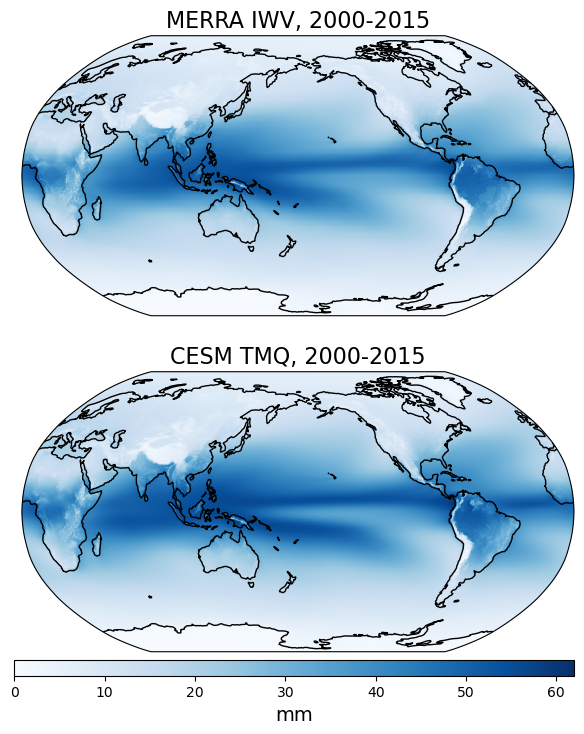

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(14,8), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

axs = axs.ravel()

cmap = mpl.colormaps.get_cmap('Blues')
vmin=0
vmax=62

# MERRA IWV [mm]
lat = IWV_merra_mean.lat
lon = IWV_merra_mean.lon
pc1 = axs[0].pcolormesh(lon, lat, IWV_merra_mean, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[0].coastlines()
axs[0].set_title('MERRA IWV, 2000-2015', fontsize=16)

# add colorbar
#cb1_ax = fig.add_axes([0.31, 0.53, 0.4, 0.02]) #(left, bottom, width, height) 
#cbar1 = plt.colorbar(pc1, cax=cb1_ax, orientation='horizontal')
#cbar1.ax.set_xlabel('mm', fontsize=14)

# CESM TMQ [kg/m^2]
lat = TMQ_cesm_mean.lat
lon = TMQ_cesm_mean.lon
pc2 = axs[1].pcolormesh(lon, lat, TMQ_cesm_mean, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].set_title('CESM TMQ, 2000-2015', fontsize=16)

# add colorbar
cb2_ax = fig.add_axes([0.31, 0.08, 0.4, 0.02])
cbar2 = plt.colorbar(pc2, cax=cb2_ax, orientation='horizontal')
cbar2.ax.set_xlabel('mm', fontsize=14)

# add title
#fig.suptitle('', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0, hspace=0.2)

#plt.savefig('../figures/toSCP/MERRA-IWV_CESM-TMQ_2000-2015.png', bbox_inches='tight')

### Remap CESM to MERRA grid

In [14]:
regridder = xe.Regridder(TMQ_cesm_month, merra_IWV_month, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x1152_361x576.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 1152) 
Output grid shape:          (361, 576) 
Periodic in longitude?      False

In [15]:
TMQ_cesm_month_merragrid = regridder(TMQ_cesm_month, keep_attrs=True)
TMQ_cesm_month_merragrid

<xarray.DataArray 'TMQ' (time: 192, lat: 361, lon: 576)>
dask.array<astype, shape=(192, 361, 576), dtype=float32, chunksize=(50, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-31 00:00:00 ... 2015-12-31 00:00:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    conventions:    CF 1.0
    creator:        Teagan King, tking@ucar.edu
    creation_date:  2023-02-17
    summary:        Create input for ClimateNet application
    contact:        Teagan King, tking@ucar.edu
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    units:          kg/m2
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    regrid_method:  bilinear

In [18]:
TMQ_cesm_month_merragrid = TMQ_cesm_month_merragrid.persist()

In [19]:
TMQ_cesm_month_merragrid_mean = TMQ_cesm_month_merragrid.mean(dim='time')
TMQ_cesm_month_merragrid_mean

<xarray.DataArray 'TMQ' (lat: 361, lon: 576)>
dask.array<mean_agg-aggregate, shape=(361, 576), dtype=float32, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

In [20]:
print(IWV_merra_mean.max().values, TMQ_cesm_month_merragrid_mean.max().values)

57.96805 60.986572


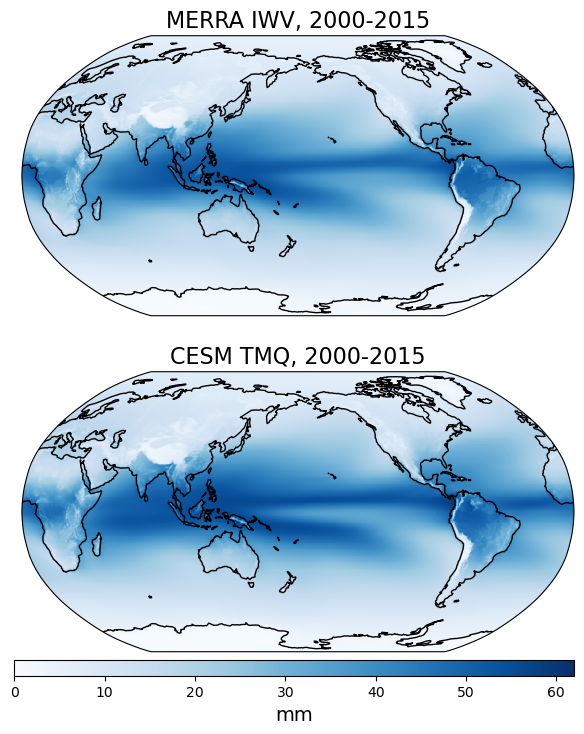

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(14,8), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

axs = axs.ravel()

cmap = mpl.colormaps.get_cmap('Blues')
vmin=0
vmax=62

# MERRA IWV [mm]
lat = IWV_merra_mean.lat
lon = IWV_merra_mean.lon
pc1 = axs[0].pcolormesh(lon, lat, IWV_merra_mean, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[0].coastlines()
axs[0].set_title('MERRA IWV, 2000-2015', fontsize=16)

# add colorbar
#cb1_ax = fig.add_axes([0.31, 0.53, 0.4, 0.02]) #(left, bottom, width, height) 
#cbar1 = plt.colorbar(pc1, cax=cb1_ax, orientation='horizontal')
#cbar1.ax.set_xlabel('mm', fontsize=14)

# CESM TMQ [kg/m^2]
lat = TMQ_cesm_month_merragrid_mean.lat
lon = TMQ_cesm_month_merragrid_mean.lon
pc2 = axs[1].pcolormesh(lon, lat, TMQ_cesm_month_merragrid_mean, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].set_title('CESM TMQ, 2000-2015', fontsize=16)

# add colorbar
cb2_ax = fig.add_axes([0.31, 0.08, 0.4, 0.02])
cbar2 = plt.colorbar(pc2, cax=cb2_ax, orientation='horizontal')
cbar2.ax.set_xlabel('mm', fontsize=14)

# add title
#fig.suptitle('', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0, hspace=0.2)

#plt.savefig('../figures/toSCP/MERRA-IWV_CESM-TMQ_2000-2015_merragrid.png', bbox_inches='tight')

### Compare regional CESM TMQ before/after regridding

In [23]:
# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds_cesm = slice(180,255)
lon_bounds_merra = slice(-180,-105)

In [24]:
TMQ_cesm_mean_WUS = TMQ_cesm_mean.sel(lat=lat_bounds, lon=lon_bounds_cesm)
TMQ_cesm_mean_WUS

<xarray.DataArray 'TMQ' (lat: 170, lon: 241)>
dask.array<getitem, shape=(170, 241), dtype=float32, chunksize=(170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0

In [25]:
TMQ_cesm_month_merragrid_mean_WUS = TMQ_cesm_month_merragrid_mean.sel(lat=lat_bounds, lon=lon_bounds_merra)
TMQ_cesm_month_merragrid_mean_WUS

<xarray.DataArray 'TMQ' (lat: 81, lon: 121)>
dask.array<getitem, shape=(81, 121), dtype=float32, chunksize=(81, 121), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0

In [26]:
print(TMQ_cesm_mean_WUS.max().values, TMQ_cesm_month_merragrid_mean_WUS.max().values)

35.12678 35.315536


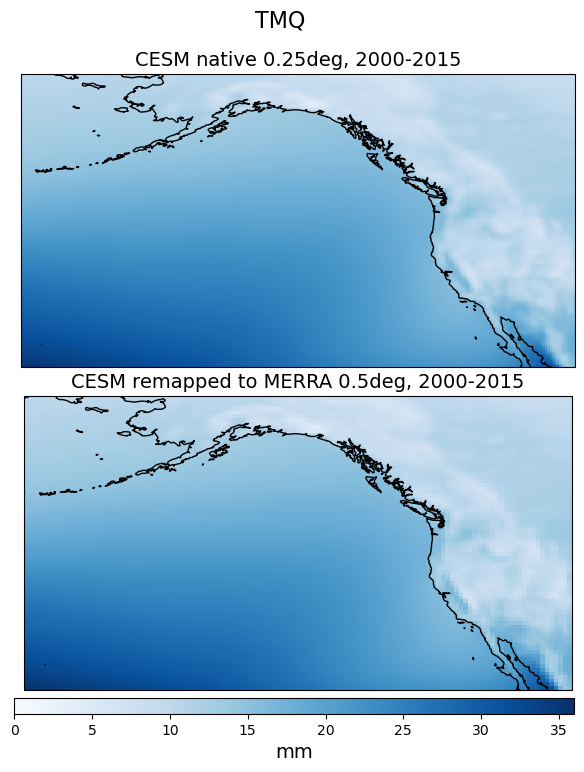

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

cmap = mpl.colormaps.get_cmap('Blues')
vmin=0
vmax=36

# CESM native 0.25deg grid
lat = TMQ_cesm_mean_WUS.lat
lon = TMQ_cesm_mean_WUS.lon
pc1 = axs[0].pcolormesh(lon, lat, TMQ_cesm_mean_WUS, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[0].coastlines()
axs[0].set_title('CESM native 0.25deg, 2000-2015', fontsize=14)

# CESM remapped to MERRA 0.5deg grid
lat = TMQ_cesm_month_merragrid_mean_WUS.lat
lon = TMQ_cesm_month_merragrid_mean_WUS.lon
pc2 = axs[1].pcolormesh(lon, lat, TMQ_cesm_month_merragrid_mean_WUS, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].set_title('CESM remapped to MERRA 0.5deg, 2000-2015', fontsize=14)

# add colorbar
cb2_ax = fig.add_axes([0.31, 0.08, 0.4, 0.02])
cbar2 = plt.colorbar(pc2, cax=cb2_ax, orientation='horizontal')
cbar2.ax.set_xlabel('mm', fontsize=14)

# add title
fig.suptitle('TMQ', fontsize=16, y=0.96)

plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../figures/toSCP/CESM-TMQ_2000-2015_compare-grids.png', bbox_inches='tight')

### Differences

In [32]:
# CESM - MERRA
TMQ_IWV_month_diff = TMQ_cesm_month_merragrid_mean - IWV_merra_mean
TMQ_IWV_month_diff

<xarray.DataArray (lat: 361, lon: 576)>
dask.array<sub, shape=(361, 576), dtype=float32, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

In [33]:
print(TMQ_IWV_month_diff.min().values, TMQ_IWV_month_diff.max().values)

-14.475815 12.4857025


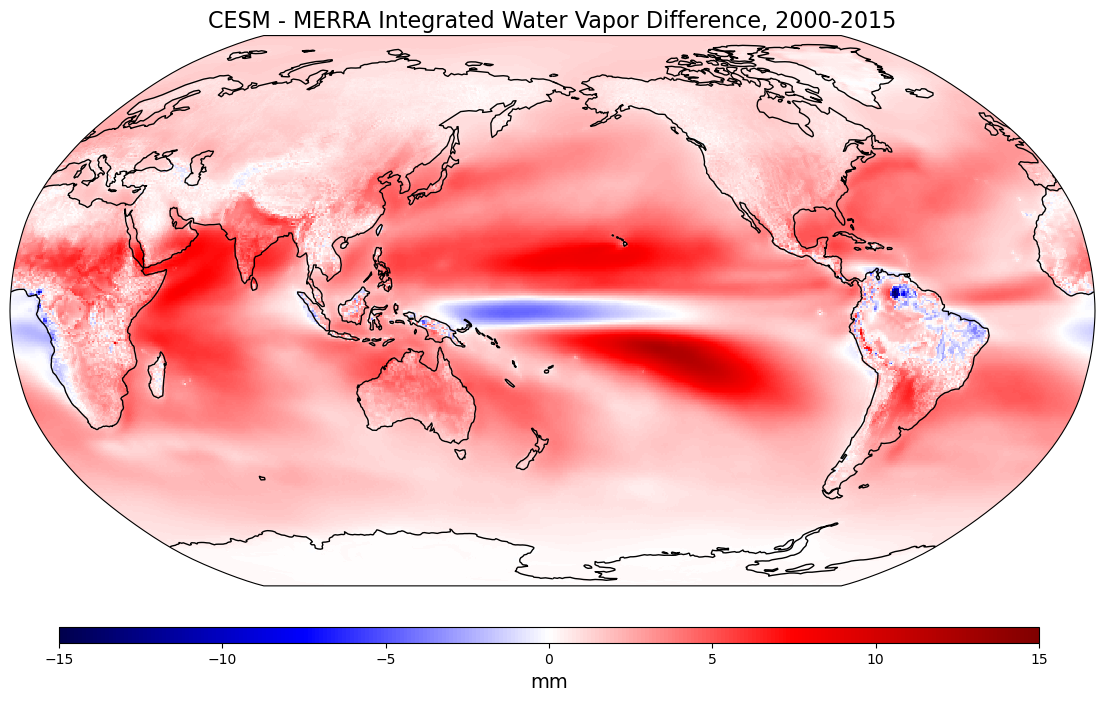

In [34]:
fig = plt.figure(figsize=(14,8))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.Robinson(central_longitude=180.0))

cmap = mpl.colormaps.get_cmap('seismic')

lat = TMQ_IWV_month_diff.lat
lon = TMQ_IWV_month_diff.lon
pc = ax.pcolormesh(lon, lat, TMQ_IWV_month_diff, cmap=cmap, vmin=-15, vmax=15, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CESM - MERRA Integrated Water Vapor Difference, 2000-2015', fontsize=16)

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02]) #(left, bottom, width, height) 
cbar = plt.colorbar(pc, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('mm', fontsize=14)

#plt.savefig('../figures/toSCP/MERRA-IWV_CESM-TMQ_2000-2015_diff.png', bbox_inches='tight')

### Monthly regional diffs

In [35]:
TMQ_cesm_month_merragrid_climo = TMQ_cesm_month_merragrid.groupby('time.month').mean()
TMQ_cesm_month_merragrid_climo

<xarray.DataArray 'TMQ' (month: 12, lat: 361, lon: 576)>
dask.array<stack, shape=(12, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    conventions:    CF 1.0
    creator:        Teagan King, tking@ucar.edu
    creation_date:  2023-02-17
    summary:        Create input for ClimateNet application
    contact:        Teagan King, tking@ucar.edu
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    units:          kg/m2
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    regrid_method:  bilinear

In [36]:
merra_IWV_month_climo

<xarray.DataArray 'IWV' (month: 12, lat: 361, lon: 576)>
dask.array<stack, shape=(12, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    _ChunkSizes:     [  1   1  91 144]
    long_name:       Integrated Water Vapor
    fmissing_value:  1000000000000000.0
    time:            0
    short_name:      IWV
    standard_name:   eastward_wind
    vmax:            1000000000000000.0
    units:           mm
    valid_range:     [-1.e+15  1.e+15]
    lev:             1000.0
    vmin:            -1000000000000000.0

In [37]:
TMQ_cesm_month_merragrid_climo_WUS = TMQ_cesm_month_merragrid_climo.sel(lat=lat_bounds, lon=lon_bounds_merra)
merra_IWV_month_climo_WUS = merra_IWV_month_climo.sel(lat=lat_bounds, lon=lon_bounds_merra)

In [38]:
# CESM - MERRA
TMQ_IWV_month_climo_WUS_diff = TMQ_cesm_month_merragrid_climo_WUS - merra_IWV_month_climo_WUS
TMQ_IWV_month_climo_WUS_diff

<xarray.DataArray (month: 12, lat: 81, lon: 121)>
dask.array<sub, shape=(12, 81, 121), dtype=float32, chunksize=(1, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [39]:
print(TMQ_IWV_month_climo_WUS_diff.min().values, TMQ_IWV_month_climo_WUS_diff.max().values)

-5.7327023 8.839634


/glade/derecho/scratch/kdagon/tmp/ipykernel_48705/1175310634.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


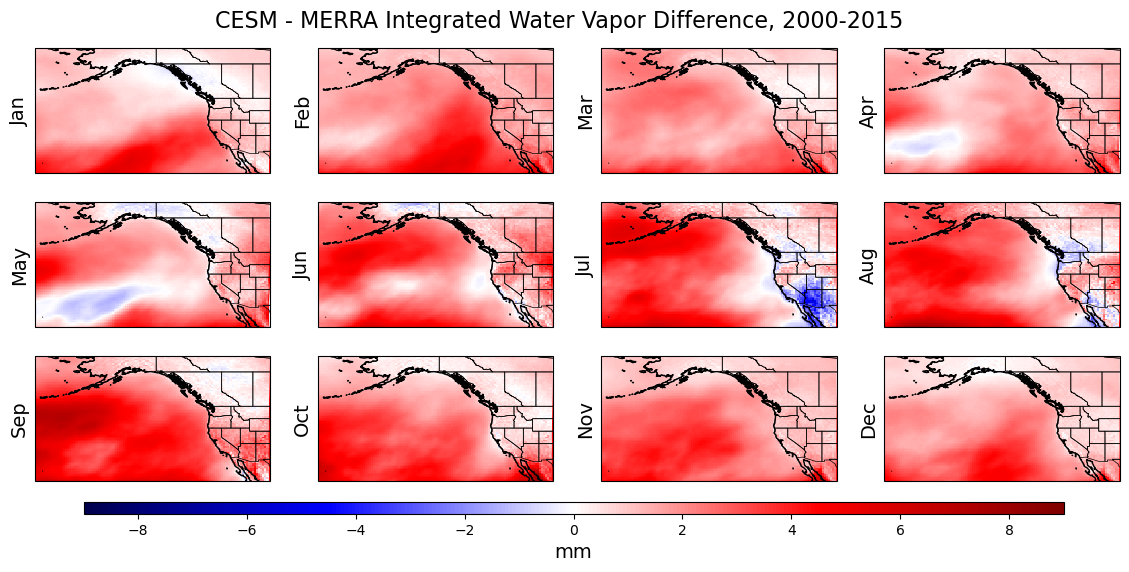

[WARNING] yaksa: 10 leaked handle pool objects


In [42]:
# a nicer plot
fig, axs = plt.subplots(3, 4, figsize=(14,6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('seismic')

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for i, m in enumerate(months):
    field, lon = add_cyclic_point(TMQ_IWV_month_climo_WUS_diff.sel(month=i+1), coord=TMQ_IWV_month_climo_WUS_diff.lon)
    lat = TMQ_IWV_month_climo_WUS_diff.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=-9, vmax=9, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(m, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('mm', fontsize=14)

# add title
fig.suptitle('CESM - MERRA Integrated Water Vapor Difference, 2000-2015', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.2, hspace=0)

#plt.savefig('../figures/toSCP/MERRA-IWV_CESM-TMQ_2000-2015_bymonth_diff.png', bbox_inches='tight')

In [ ]:
client.close()
cluster.close()